<a href="https://colab.research.google.com/github/QWERTY051310/GDSC_WP/blob/main/Assignment3_GDSCWP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.utils.data as loader
from torch.utils.data import DataLoader
from torchvision import datasets
import torchvision.transforms as transforms

In [2]:
#defining transforms

train_transform = transforms.Compose([
    transforms.RandomRotation(degrees=15),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5],[0.5, 0.5, 0.5])
])

In [3]:
#getting train and test data

train_data = torchvision.datasets.CIFAR10(root = '/content/drive/MyDrive/GDSCWP/CIFAR10/traindata',
                                          train = True,
                                          download = True,
                                          transform = train_transform)

test_data = torchvision.datasets.CIFAR10(root = '/content/drive/MyDrive/GDSCWP/CIFAR10/testdata',
                                         train = False,
                                         download = True,
                                         transform = test_transform)

100%|██████████| 170498071/170498071 [00:02<00:00, 77803828.54it/s]


Extracting /content/drive/MyDrive/GDSCWP/CIFAR10/traindata/cifar-10-python.tar.gz to /content/drive/MyDrive/GDSCWP/CIFAR10/traindata


100%|██████████| 170498071/170498071 [00:02<00:00, 66974078.03it/s]


Extracting /content/drive/MyDrive/GDSCWP/CIFAR10/testdata/cifar-10-python.tar.gz to /content/drive/MyDrive/GDSCWP/CIFAR10/testdata


In [4]:
class_names = train_data.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [5]:
#loading the train and test data
batchsize = 5

train_loader = loader.DataLoader(train_data, batch_size = batchsize, shuffle = True)
test_loader = loader.DataLoader(test_data, batch_size = batchsize, shuffle = False)

classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

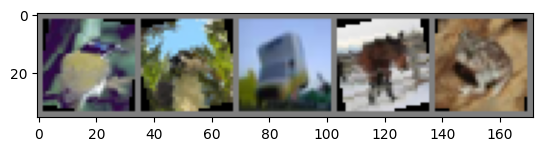

bird  bird  truck horse frog 


In [6]:
# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batchsize)))

In [7]:
class ImageClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(3*32*32, 1024)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(1024, 512)
        self.linear3 = nn.Linear(512, 10)  # Output for 10 classes

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.relu(x)
        x = self.linear3(x)
        x = nn.functional.softmax(x, dim=1)  # Apply softmax activation
        return x


In [8]:
# Initialise the model, loss function and optimizer
model = ImageClassifier()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [9]:
#training
epochs = 5

for epoch in range(epochs):
  model.train()
  for i, (inputs, labels) in enumerate(train_loader):
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

In [10]:
# Switch model to evaluation mode
model.eval()

# Initialize variables to track performance
total_samples = 0
correct_predictions = 0

# Disable gradient computations
with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)

        # Get the predicted class (the one with the highest probability)
        _, predicted = torch.max(outputs.data, 1)

        # Update total and correct counts
        total_samples += targets.size(0)
        correct_predictions += (predicted == targets).sum().item()

# Calculate accuracy
accuracy = 100 * correct_predictions / total_samples
print(f'Accuracy of the model on the test data: {accuracy:.2f}%')

Accuracy of the model on the test data: 37.89%


In [11]:
#LEAST CONFIDENCE
least_confidence = 0

with torch.no_grad():
    for inputs, targets in test_loader:
      # Calculate confidence
      confidence = 1 - torch.max(outputs.data, dim = 0)[0]

      # Update least confidence
      if torch.max(confidence) > least_confidence:
        least_confidence = torch.max(confidence)

print(f'Least Confidence of the model is: {least_confidence:.2f}')

Least Confidence of the model is: 1.00


In [12]:
#MARGIN SAMPLING
margin_confidence = 0

with torch.no_grad():
    for inputs, targets in test_loader:
      #calculate margin
      margin = torch.topk(outputs.data, k = 2, dim = 0)[0] - torch.topk(outputs.data, k = 2, dim = 0)[1]

      #update margin
      if torch.max(margin) > margin_confidence:
        margin_confidence = torch.max(margin)

print(f'Margin of Confidence of the model is: {margin_confidence:.2f}')

Margin of Confidence of the model is: 0.08


In [13]:
#PREDICTION ENTROPY
pred_entropy = 0

with torch.no_grad():
    for inputs, targets in test_loader:
      log_outputs = torch.log(outputs.data)
      entropy = outputs.data * log_outputs
      neg_entropy_sum = -torch.sum(entropy)

      if neg_entropy_sum > pred_entropy:
        pred_entropy = neg_entropy_sum

print(f'Prediction Entropy of the model is: {pred_entropy:.2f}')


Prediction Entropy of the model is: 0.42


In [14]:
#CONTRASTIVE ACTIVE LEARNING (5 nearest neighbours)

kl_div_confidence = 0

with torch.no_grad():
    for inputs, targets in test_loader:
      kl_div_sum = 0
      for i in range(4):
        kl_div_sum += torch.nn.functional.kl_div(outputs.data[i+1], outputs.data[0])
        #print(kl_div_sum)


      kl_div_avg = kl_div_sum/5

      if kl_div_avg < kl_div_confidence:
        kl_div_confidence = kl_div_avg

print(f'KL Divergence Confidence of the model is: {-kl_div_confidence:0.2f}')

/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:2943: UserWarning: reduction: 'mean' divides the total loss by both the batch size and the support size.'batchmean' divides only by the batch size, and aligns with the KL div math definition.'mean' will be changed to behave the same as 'batchmean' in the next major release.
  warnings.warn(


KL Divergence Confidence of the model is: 0.06


In [18]:
#COSINE SIMILARITY (5 nearest neighbours)
avg_cos_similarity = 0

with torch.no_grad():
    for inputs, targets in test_loader:
      cos_similarity_sum = 0
      for i in range(4):
        cos_similarity_sum += torch.nn.functional.cosine_similarity(outputs.data[i+1], outputs.data[0], dim = 0)

      #avg_cos_similarity += cos_similarity_sum


fin_avg_cos_sim = cos_similarity_sum/5

print(f'Cosine Diversity of the model is: {1 - fin_avg_cos_sim:0.2f}')

Cosine Diversity of the model is: 0.60


In [17]:
#L2 NORM (5 nearest neighbours)
avg_l2_norm = 0

with torch.no_grad():
    for inputs, targets in test_loader:
      l2_norm_sum = 0
      for i in range(4):
        l2_norm_sum += torch.nn.functional.pairwise_distance(outputs.data[i+1], outputs.data[0])

      #avg_l2_norm += l2_norm_sum


fin_avg_l2_norm = l2_norm_sum/5

print(f'L2 Norm Diversity of the model is: {fin_avg_l2_norm:0.2f}')

L2 Norm Diversity of the model is: 0.58
